In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/eop/code/rl/Model_Generalization_Code_supplement/venv/lib/python3.10/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


(Array([2, 1], dtype=int32),
 Array([[1, 2]], dtype=int32),
 Array([0, 0], dtype=int32))

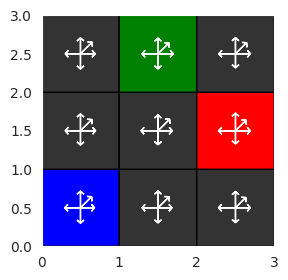

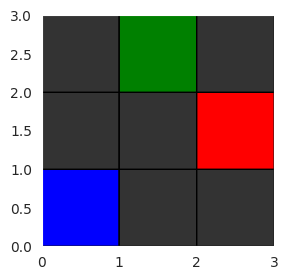

In [9]:
from types import SimpleNamespace
import os
os.environ['CUDA'] = '/usr/local/cuda-12'
os.environ['PATH'] = '/usr/local/cuda-12/bin${PATH:+:${PATH}}'

import jax as jx
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import colormaps
import json
import environments
import math
from vq_vae import *
import pickle as pkl

with open('configs/EW_VQVAE_simple_model.json', 'r') as f:
    config = json.load(f)

def render(state):
    goal, enemy_coords, pos = state
    cmap = colors.ListedColormap(['#333333','red', 'green', 'blue'])
    arr = np.zeros((env.grid_size, env.grid_size))
    arr[goal[0], goal[1]] = 2
    arr[pos[0], pos[1]] = 3
    for enemy_coord in enemy_coords:
        arr[enemy_coord[0], enemy_coord[1]] = 1
    plt.figure(figsize=(3,3))
    plt.pcolor(arr, cmap=cmap, edgecolors='k', linewidths=1, vmin=0, vmax=3)

def render_q(stat):
    render(stat)
    scale = 1
    goal, enemy_coords, player = stat
    move_map = env.move_map.astype(float)
    move_map = move_map.at[0].set([1/math.sqrt(2), 1/math.sqrt(2)]) # plot inaction as diagonal
    for i in range(env.grid_size):
        for j in range(env.grid_size):
            player = jnp.array((i, j))
            ob = env.get_observation((goal, enemy_coords, player))
            qs = Q_func(params['Q'][seed_id], ob)
            qs = jx.nn.softmax(qs)

            for a, q in enumerate(qs):
                arr_dir = move_map[a]
                plt.arrow(player[1] + 0.5, player[0] + 0.5, scale*arr_dir[1]*q, scale*arr_dir[0]*q, head_width=0.09, head_length=0.04, length_includes_head=True, color='white', overhang=1)

def render_obs(obs, ax=None):
    grid_shape = (env.grid_size, env.grid_size)
    obs2 = np.reshape(np.array(obs, dtype=int), (*grid_shape, 4))
    player, goal, enemy = obs2[:,:,0], obs2[:,:,1], obs2[:,:,2]
    cmap = colors.ListedColormap(['#333333','red', 'green', 'blue'])
    arr = np.zeros(grid_shape)
    arr += enemy
    arr = np.maximum(arr, goal * 2)
    arr = np.maximum(arr, player * 3)
    if ax is None:
        plt.figure(figsize=(3,3))
        plt.pcolor(arr, cmap=cmap, edgecolors='k', linewidths=1, vmin=0, vmax=3)
    else:
        ax.pcolor(arr, cmap=cmap, edgecolors='k', linewidths=1, vmin=0, vmax=3)


def set_default(d, k, v):
    if k not in d:
        d[k] = v

set_default(config, "double_DQN", False)
set_default(config, "episodic_env", False)
set_default(config, "updates_per_step", 1)
set_default(config, "save_final_params", True)
config = SimpleNamespace(**config)

Environment = getattr(environments, config.environment)

env_config = config.env_config

key = jx.random.PRNGKey(600)
seed_id = 2
env = Environment(**env_config)
num_actions = env.num_actions()




with open('out/EW_VQ_VAE_simple_model.params', 'rb') as f:
    params = pkl.load(f)
with open('out/EW_VQ_VAE_simple_model.states', 'rb') as f:
    states = pkl.load(f)

state, obs = env.reset(key)

Q_net = hk.without_apply_rng(hk.transform(lambda obs: Q_function(config, env.num_actions())(obs)))
Q_func = Q_net.apply
render_q(state)
render_obs(obs)
state

(None, None)

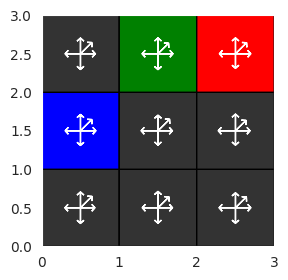

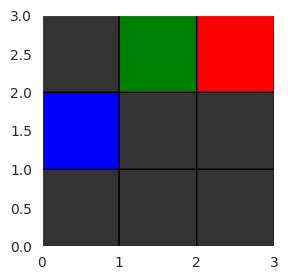

In [10]:
key, subkey = jx.random.split(key)
action0 = 3
new_state, new_obs, rew, terminal, info = env.step(subkey, state, action0)
render_q(new_state), render_obs(new_obs)

In [11]:
dummy_a = jnp.zeros((env.num_actions()))

reward_net = hk.without_apply_rng(hk.transform(lambda obs, a, emb: reward_decoder(config)(obs, a, emb)))
reward_params = params['model'][seed_id]['reward']
reward_func = reward_net.apply

termination_net = hk.without_apply_rng(hk.transform(lambda obs, a, emb: termination_decoder(config)(obs, a, emb)))
termination_params = params['model'][seed_id]['termination']
termination_func = termination_net.apply

next_obs_net = hk.without_apply_rng(
    hk.transform(lambda obs, a, emb, key: next_obs_decoder(config, obs.shape[-1])(obs, a, emb, key)))
next_obs_params = params['model'][seed_id]['next_obs']
next_obs_func = next_obs_net.apply

encoder_net = hk.without_apply_rng(
    hk.transform_with_state(lambda obs, action, next_obs, reward, termination, is_training:
                            Encoder(config)(obs, action, next_obs, reward, termination, is_training)))
encoder_params = params['model'][seed_id]['encoder']
encoder_state = states['model'][seed_id]['encoder']

encoder_func = encoder_net.apply

quantize_fun = hk.without_apply_rng(
    hk.transform_with_state(lambda encoding_indices: Encoder(config).vq.quantize(encoding_indices)))


def prior_func(prior_logits, encoder_params, encoder_state, key):
    out, enc_state = quantize_fun.apply(encoder_params, encoder_state,
                                        jx.random.categorical(key, jnp.log(prior_logits)))
    return jx.lax.stop_gradient(out)
prior_state = states['model'][seed_id]['prior']


model_funcs = {"reward": reward_func, "termination": termination_func, "next_obs": next_obs_func,
               "encoder": encoder_func, "prior": prior_func}

model_params = [{"reward": rp, "termination": tp, "next_obs": no, "encoder": ep} for rp, tp, no, ep in
                zip(reward_params, termination_params, next_obs_params, encoder_params)]

Predicted:


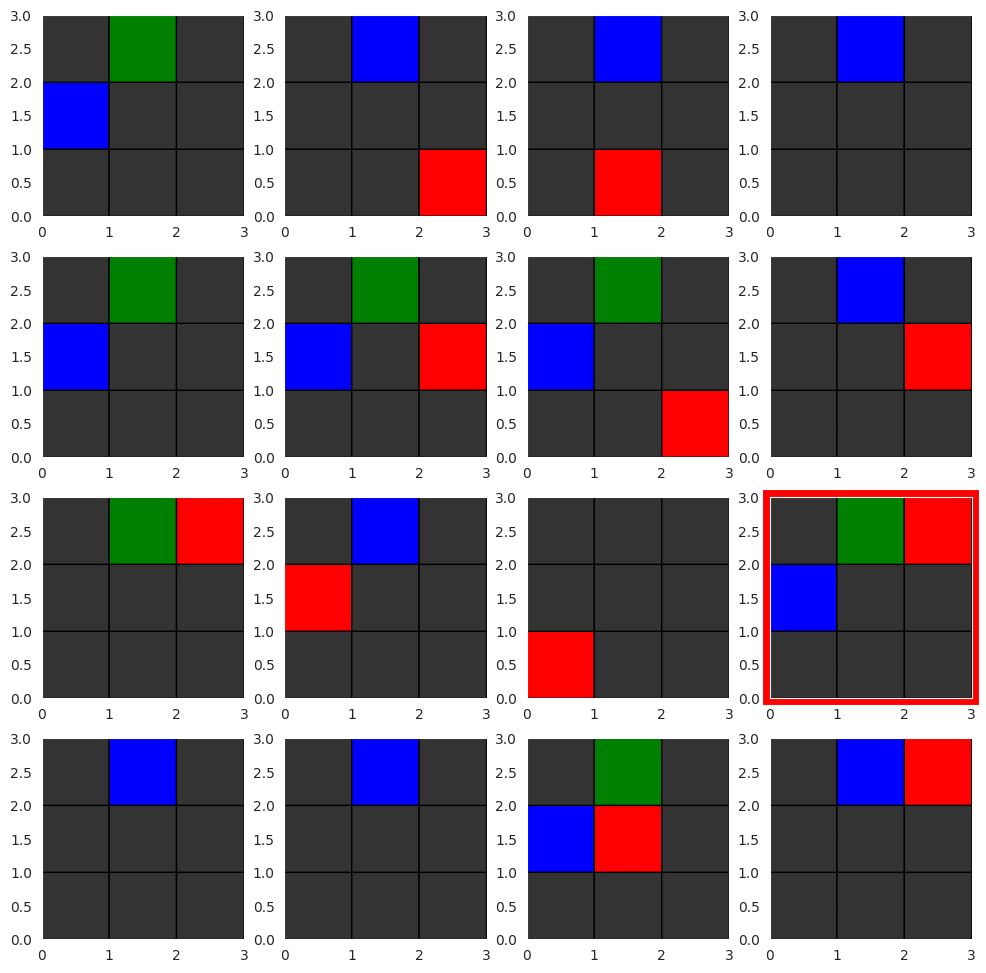

Enemy probs:


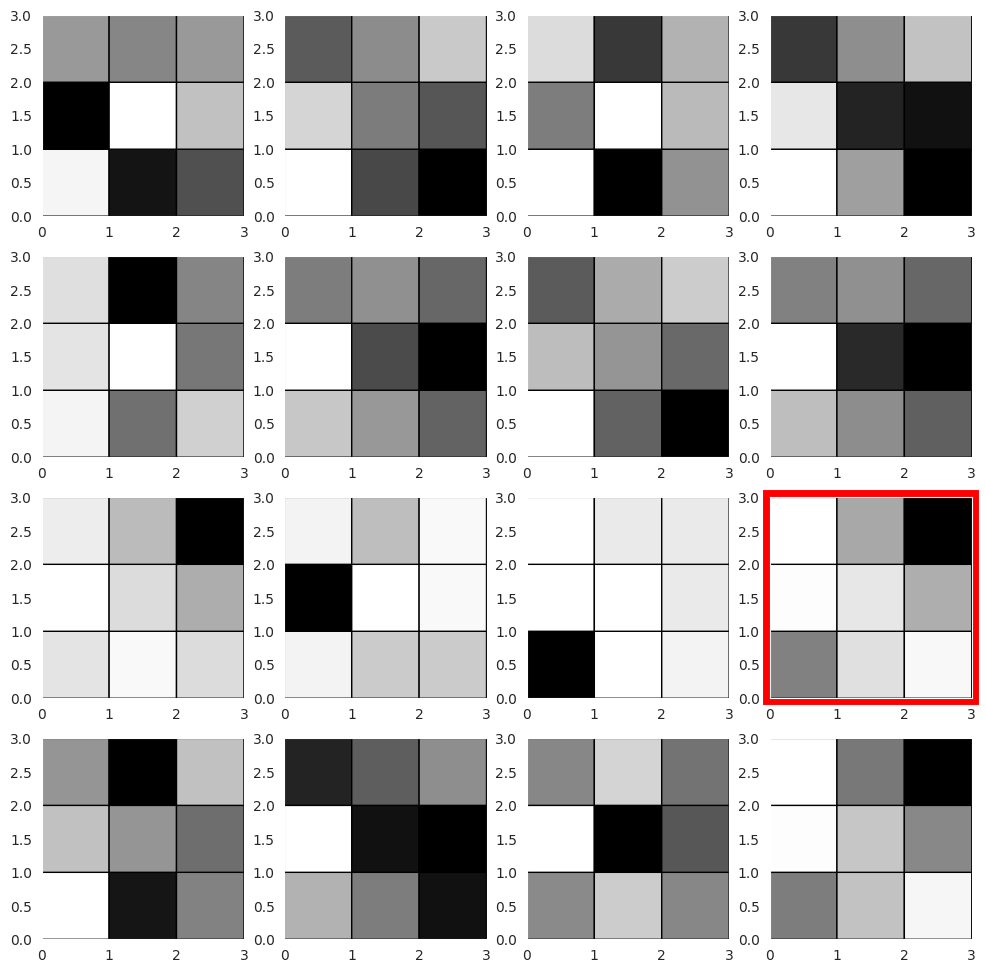

s:


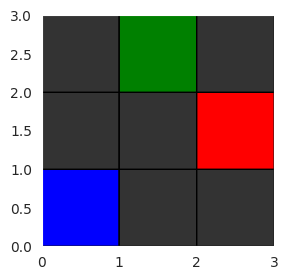

s':


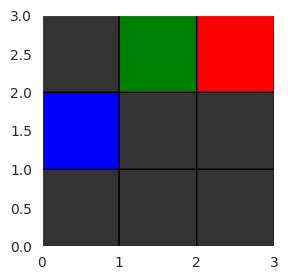

In [12]:
encoded = encoder_func(encoder_params, encoder_state, obs, jnp.eye(num_actions)[action0], new_obs, rew, terminal, False)
encoding_ind = encoded[0]['encoding_indices'].item()

def render_enemy_probs(logits, ax=plt):
    grid_shape = (env.grid_size, env.grid_size)
    obs2 = np.reshape(np.array(logits, dtype=int), (*grid_shape, 4))
    player, goal, enemy = obs2[:,:,0], obs2[:,:,1], obs2[:,:,2]
    arr = np.zeros(grid_shape)
    arr += enemy

    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.pcolor(arr, cmap='Grays', edgecolors='k', linewidths=1)
    # fig.colorbar(im, cax=cax, orientation='vertical')

def draw_border(ax):
    ax.patch.set_linewidth(10)
    ax.patch.set_edgecolor('red')

    # ax.spines['bottom'].set_color('0.5')
    # ax.spines['top'].set_color('0.5')
    # ax.spines['right'].set_color('0.5')
    # ax.spines['left'].set_color('0.5')

print('Predicted:')
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    next_obs, logits = next_obs_func(
        next_obs_params,
        obs,
        jnp.eye(num_actions)[action0],
        quantize_fun.apply(encoder_params, encoder_state, i)[0],
        key)
    render_obs(next_obs, ax)
    if i == encoding_ind:
       draw_border(ax)
plt.show()
print('Enemy probs:')
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
for i, ax in enumerate(np.array(axs).flatten()):
    next_obs, logits = next_obs_func(
        next_obs_params,
        obs,
        jnp.eye(num_actions)[action0],
        quantize_fun.apply(encoder_params, encoder_state, i)[0],
        key)
    render_enemy_probs(logits['logit'], ax)
    if i == encoding_ind:
        draw_border(ax)

plt.show()
print('s:')
render_obs(obs)
plt.show()
print("s':")
render_obs(new_obs)

<BarContainer object of 16 artists>

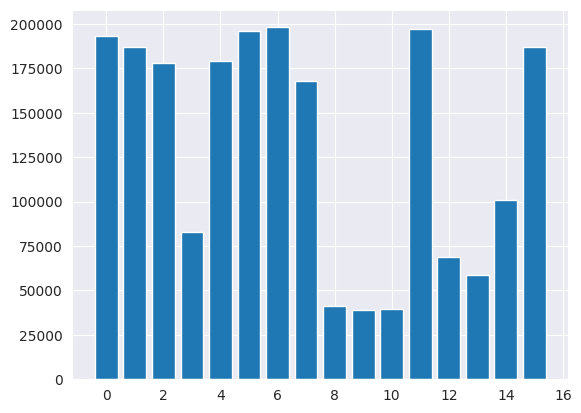

In [13]:
plt.bar(range(16), prior_state)

In [14]:
curr_obs = obs
curr_state = state

Rew: -0.05 {'mu': Array(-0.04423624, dtype=float32), 'sigma': Array(1., dtype=float32)}


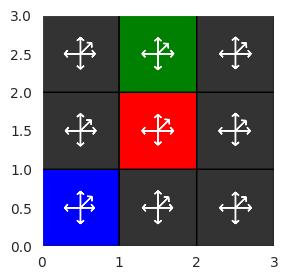

In [15]:
act = 2

prev_state, prev_obs = curr_state, curr_obs
curr_state, curr_obs, curr_rew, cur_terminal, _ = env.step(key, curr_state, act)
render_q(curr_state)
emb = quantize_fun.apply(encoder_params, encoder_state, 0)[0]
print('Rew:', curr_rew, reward_func(reward_params, curr_obs, jnp.eye(num_actions)[act], emb))